# Meaning-Based Music Recommendation

#### Summary:
- Use natural language processing for music recommendation
- Identify and suggest music with similar meanings as songs entered by the user

#### Key Questions:
- How do we obtain song 'meanings'?
- How do we measure the similarities between songs based on texts related to song 'meanings'?
- How do we produce a list of recommendations for a given user?

---
## Section 1: Gather song lyrics and Songmeanings.com comments/interpretations

Songmeanings.com contains <b>1,097,225 song lyrics</b> from <b>110,886 artists</b>, and <b>1,737,493 comments/interpretations</b>. To obtain song lyrics/comments, we need to obtain the URLs to the song lyrics/comments page for ~1 million songs. We will use a small premade website index info file (sm_start_info.xlsx) to build out a list of URLs to the A-Z artist directory pages. From there, we will use BeautifulSoup to webscrape the <b>URLs of all 110,886 artist pages</b>, which in turn we will webscrape to obtain the <b>URLs of all 1,097,225 song pages</b>.

In [1]:
%matplotlib inline

# Imports
import numpy as np
import pandas as pd
import requests
import bs4
from bs4 import BeautifulSoup
from IPython.display import clear_output
from time import sleep
from matplotlib import pyplot as plt

In [2]:
# Load Songmeanings.com directory info 
start_info = pd.read_excel('sm_start_info.xlsx')
start_info.head()

,letter,pages
0,a,155
1,b,170
2,c,153
3,d,161
4,e,76


In [3]:
# Build list of URLs to access artist directories
artist_dir_urls = []
for letter, max_page in start_info.values:
    for page in np.arange(1,max_page+1):
        artist_dir_urls.append('https://songmeanings.com/artist/directory/'+letter+'/?page='+str(page))
artist_dir_urls[:5]

['https://songmeanings.com/artist/directory/a/?page=1',
 'https://songmeanings.com/artist/directory/a/?page=2',
 'https://songmeanings.com/artist/directory/a/?page=3',
 'https://songmeanings.com/artist/directory/a/?page=4',
 'https://songmeanings.com/artist/directory/a/?page=5']

![](artist_dir_page.png)

In [4]:
# Build list of URLs to artist pages 
SCRAPE_ARTIST_URLS = False # Set to False if scraping is already completed

if SCRAPE_ARTIST_URLS == True:
    artist_urls = []
    for artists_page in artist_dir_urls:
        page = requests.get(artists_page)
        soup = BeautifulSoup(page.text, 'lxml')
        table = soup.find('table', summary='songs table')
        table_body = table.find('tbody')
        for item in table_body.find_all('a', href=True):
            artist_urls.append([(item['title']),(item['href'])])
        print ('Scraping artist URLs: '+artists_page)
        clear_output(wait=True)
        sleep(1)
    # Save artist URL list
    artist_urls_df = pd.DataFrame(artist_urls)
    artist_urls_df.to_csv('artist_urls.csv', index=False, header=False)
else:
    artist_urls_df = pd.read_csv('artist_urls.csv', header=None)

In [5]:
artist_urls_df.columns = ['Artist','URL']
artist_urls_df.head()

,Artist,URL
0,A,//songmeanings.com/artist/view/songs/6024/
1,A B,//songmeanings.com/artist/view/songs/137439043...
2,A B & The Sea,//songmeanings.com/artist/view/songs/137438996...
3,A Backward Glance On A Travel Road,//songmeanings.com/artist/view/songs/137439060...
4,A Balladeer,//songmeanings.com/artist/view/songs/137438972...


![](artist_page.png)

In [6]:
# Build list of URLs to song pages 
SCRAPE_SONG_URLS = False # Set to False if scraping is already completed

if SCRAPE_SONG_URLS == True:
    # Save checkpoints
    checkpoints = np.arange(0,110000,1000)

    for count, artist in enumerate(artist_urls_df.values):
        page = requests.get('http:'+artist[1])
        soup = BeautifulSoup(page.text, 'lxml')
        table = soup.find('table', summary='songs table')
        if table != None:
            table_body = table.find('tbody')
            for item in table_body.find_all('tr'):
                song_name = item.find_all('a')[0].contents[0]
                song_url = item.find_all('a')[0]['href']
                num_comments = item.find_all('a')[1].contents[0]
                song_urls.append([artist[0], song_name, song_url, num_comments])
        print('Scraping song URLs for artist: '+artist[0])
        clear_output(wait=True)
        sleep(1)

        # Save at checkpoint
        if count in checkpoints:
            song_urls_df = pd.DataFrame(song_urls)
            song_urls_df.to_csv('song_urls.csv', index=False, header=False)

    song_urls_df = pd.DataFrame(song_urls)
    song_urls_df.to_csv('song_urls.csv', index=False, header=False)
else:
    song_urls_df = pd.read_csv('song_urls.csv', header = None)

In [7]:
song_urls_df.columns = ['Artist','Song','URL','Number of comments']
song_urls_df.head()

,Artist,Song,URL,Number of comments
0,A,"""meditacao"" - (eng: Meditation)",//songmeanings.com/songs/view/91590/,0
1,A,2nd Coming,//songmeanings.com/songs/view/3530822107859283...,0
2,A,40,//songmeanings.com/songs/view/3530822107858486...,0
3,A,6 O'clock On A Tube Stop,//songmeanings.com/songs/view/93649/,1
4,A,8 Fingers,//songmeanings.com/songs/view/3530822107858486...,2


In [8]:
len(song_urls_df[song_urls_df['Number of comments']>=1])

226743

About 20% of songs on Songmeanings.com have at least 1 comment.

In [9]:
len(song_urls_df[song_urls_df['Number of comments']>=10])

37648

About 3% of songs have at least 10 comments.

For this project, we limit our analysis to songs with at least 10 user comments, resulting in 37647 songs. This allows us to have both lyrics and a good amount of comment data for every song. There is also a practical consideration; scraping 1 million songs would take 555 hours (23 days) assuming a 2 second delay between requests.

![](song_page.png)

In [10]:
# Functions to extract strings (exclude tagged items) from soup items
def extract_str(soup_item):
    string = []
    if soup_item is not None:
        for item in soup_item:
            if isinstance(item,bs4.element.NavigableString):
                string.append(item)
        joined_string = ' '.join(string)
        return joined_string

def strip_header_literals(string):
    if string is not None:
        output = string.replace('\n','',1).replace('\t','')
        return output

In [11]:
# Webscrape song lyrics and user comments/interpretations
SCRAPE_TEXT = False # Set to False if scraping is already completed

if SCRAPE_TEXT == True:    
    song_lyrics = []
    song_comments = []
    song_ID_counter = 1

    checkpoints = np.arange(0,len(song_urls_df[song_urls_df[3]>10]),1000)

    # For each song
    for song in song_urls_df.values: 
        if song[3]>=10: # If song has 10 or more comments

            # Scrape song page
            page = requests.get('http:'+song[2])
            soup = BeautifulSoup(page.text, 'lxml')

            # Lyrics
            lyrics_box = soup.find('div', {'class': "holder lyric-box"})
            lyrics = strip_header_literals(extract_str(lyrics_box))
            # Save song lyrics (song ID, artist, song name, lyrics)
            song_lyrics.append([song_ID_counter, song[0],song[1],lyrics])

            # Comments
            raw_comments = soup.find('ul', {'class': "comments-list"})
            comments = []
            if raw_comments is not None: 
                for raw_comment_count, raw_comment in enumerate(raw_comments.find_all('li')):
                    if raw_comment_count % 2 == 0: # skip odd items, which are replies to comments
                        comments.append(strip_header_literals(extract_str((raw_comment.find('div', {'class':'text'})))))
                # Save song comments (song ID, artist, song name, comment)
                for comment in comments:
                    song_comments.append([song_ID_counter, song[0],song[1],comment])

            # Increase song ID counter
            song_ID_counter += 1

            # Save at checkpoint
            if song_ID_counter in checkpoints:
                song_lyrics_df = pd.DataFrame(song_lyrics)
                song_lyrics_df.to_csv('song_lyrics.csv', index=False, header=False)

                song_comments_df = pd.DataFrame(song_comments)
                song_comments_df.to_csv('song_comments.csv', index=False, header=False)

            # Update progress
            print ('Scraping ARTIST: '+song[0]+', SONG: '+song[1])
            clear_output(wait=True)
            sleep(1)

    song_lyrics_df = pd.DataFrame(song_lyrics)
    song_lyrics_df.to_csv('song_lyrics.csv', index=False, header=False)

    song_comments_df = pd.DataFrame(song_comments)
    song_comments_df.to_csv('song_comments.csv', index=False, header=False)
else: 
    song_lyrics_df = pd.read_csv('song_lyrics.csv', header = None)
    song_comments_df = pd.read_csv('song_comments.csv', header = None)

#### Lyrics

In [12]:
song_lyrics_df.columns = ['ID','Artist','Song','Lyrics']
song_lyrics_df['Length'] = song_lyrics_df['Lyrics'].apply(lambda x: len(str(x)))
song_lyrics_df.head()

,ID,Artist,Song,Lyrics,Length
0,1,A,Starbucks,"She's silver rich, I cannot take no more yeah ...",1799
1,2,A Black Rose Burial,A Baleful Aura In The Graveyard Of Broken Gears,far beyond appolyons lair \r\r\nacross the se...,1572
2,3,A Change of Pace,A Farewell to a Friendship,In a dream \r\nIn a place \r\nWhere the far re...,1376
3,4,A Change of Pace,Loose Lips Sink Ships,So I made you lie! \r\n \r\nAnd we both hope \...,1146
4,5,A Change of Pace,Shoot From The Hip,Picture perfect turned to worthless \r\nBitter...,1611


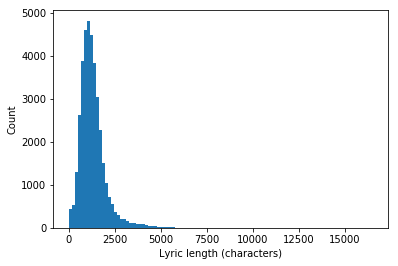

In [13]:
plt.hist(song_lyrics_df['Length'], 100)
plt.xlabel('Lyric length (characters)')
plt.ylabel('Count');

#### Comments

Comments are contributed by Songmeanings.com users and could vary greatly by length and the level of discussion/interpretation of song lyrics.

In [14]:
song_comments_df.columns = ['ID','Artist','Song','Comment']
song_comments_df['Length'] = song_comments_df['Comment'].apply(lambda x: len(str(x)))
song_comments_df.head()

,ID,Artist,Song,Comment,Length
0,1,A,Starbucks,this song is cool.....xxxxxx\r\n \r\n \r\n,37
1,1,A,Starbucks,"this song rules, so does thier albums. go A!!...",58
2,1,A,Starbucks,"I love it, but itd be nice if sum1 got the ly...",65
3,1,A,Starbucks,any1 know what this song is about?\r\n \r\n \r\n,43
4,1,A,Starbucks,its about what would you rather do: be a rock...,81


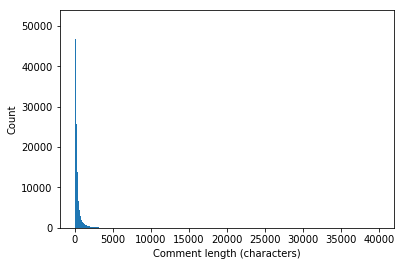

In [15]:
plt.hist(song_comments_df['Length'], 1000)
plt.xlabel('Comment length (characters)')
plt.ylabel('Count');

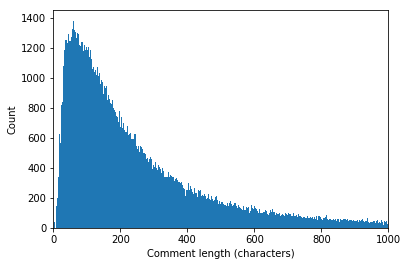

In [16]:
plt.hist(song_comments_df[song_comments_df['Length']<=1000]['Length'], 1000)
plt.xlabel('Comment length (characters)')
plt.xlim(0,1000)
plt.ylabel('Count');

## How do the contents of shorter vs. longer comments (by quartiles) differ?

In [17]:
song_comments_df['Length'].describe()

count    375678.000000
mean        356.830014
std         578.471175
min           2.000000
25%          94.000000
50%         190.000000
75%         385.000000
max       40003.000000
Name: Length, dtype: float64

#### Comments with between 0 to 100 characters mostly lack discussion about song content

In [18]:
def remove_linebreak(raw_str):
    out = str(raw_str).replace('\n','').replace('\r','')
    return out

In [19]:
for comment in song_comments_df[song_comments_df['Length']<=100]['Comment'].sample(4, random_state = 0):
    print(remove_linebreak(comment)+'\n')

 it makes me feel like dying but in a good way...... if any of u know what i mean  

 Everyone needs homies, they have your back no matter what,  

 i agree with u tainted , this was my 1st song i heard by them and its my fave song ;D  

 oh my...  :)  



#### Comments with between 100 and 200 characters show some discussion about what the song is about

In [20]:
for comment in song_comments_df[(song_comments_df['Length']>100) & 
                                (song_comments_df['Length']<=200)]['Comment'].sample(4, random_state = 42):
    print(remove_linebreak(comment)+'\n')

 this is about war!whether its between God and satan,or if its between to colliding men.........  

 what cd is this one on?  i thought i'd heard all the metric songs, guess not! it looks good though.  

 i think this song is about two people who love each other no matter how low they are in society. Its sayin that they will love each other no matter what.  

 I always thought he was saying "It's a corn beef sky" instead of "orangey sky" hahaha. Anyway, just bought this on vinyl, it's a great album and song.   



#### Comments with between 200 and 400 characters contain more detailed descriptions of songs, sometimes quotes song lyrics

In [21]:
for comment in song_comments_df[(song_comments_df['Length']>200) & 
                                (song_comments_df['Length']<=400)]['Comment'].sample(4, random_state = 0):
    print(remove_linebreak(comment)+'\n')

 Yeah.  Not only is he trying to tell kids to be better people, I felt he was also trying to shy them away from the evils of the music industry and the artists and images that promote those evils.  

 Even though iÂ´m not a Miley Cyrus neither a Jonas brother fan  I think this song is excellent and one of their best songs.  They sound great together.  This song is very powerful and meaningful. It is about their break up, but now they are back together  iÂ´m happy for them they are great together.  

 I totally agree with you, this song is very powerful. I love the subliminal sounds, like: don't go and leave me sounds like don't "god" leave me...   My favorite line is also your eyes forever glued to mine, it's standing in my msn nick at the moment :).  I trully believe this song is one of placebo's best work ever. Can't wait to see the video on this one...  

 Its kind of funny to me, my interpretation may be different from the majority, but I think its pretty dark. To me its a man infe

#### Comments with between 400 and 4000 characters cotain a high level of detailed specifics

In [22]:
for comment in song_comments_df[song_comments_df['Length']>400]['Comment'].sample(4, random_state = 0):
    print(remove_linebreak(comment)+'\n')

 I don't think this song is about assisted suicide.  I think the song is about Judas's struggles after betraying Jesus.  "To convalesce from empty sorrow, someone had to squeal" - Jesus needed to die and Judas was the one who had to betray Him.  "You said "I know." I know it's not your fault" - Jesus basically tells Judas that He knows that Judas has betrayed Him and tells him to go do it. (Matthew 26)   "How much were you paid to sell out the madman?" - Judas sold Jesus to the Sanhedrin for 20 pieces of silver.  "The innocent will rest in the peace they've been given" - Judas muses that the innocent will find peace (salvation) which Jesus gives to us as a gift.  The song seems to be a lot of Judas dealing with his betrayal of Jesus and how he can't handle it anymore.  This is by no means the only way to interpret it, but it think that is is at least somewhat the meaning that Haste the Day was going for.  

 this is disenchanted:  Well I was there on the day They sold the cause for the

---
We can grade the quality of each comment by which of these quartiles they fall into. Later, we can choose to exclude the lowest quartile comments from text analysis or change the weight of lower quality comments if needed.

In [23]:
def length_grade(comment_length):
    if comment_length<=100:
        return 1
    if (comment_length>100) & (comment_length<=200):
        return 2
    if (comment_length>200) & (comment_length<=400):
        return 3
    if comment_length>400:
        return 4

song_comments_df['Length_grade'] = song_comments_df['Length'].apply(lambda x: length_grade(x))
song_comments_df.sample(5, random_state = 0)

,ID,Artist,Song,Comment,Length,Length_grade
319059,31978,Spandau Ballet,Gold,"Well, clearly the song is about a mad scienti...",1357,4
260966,26150,Pedro the Lion,Promise,A friend wanted me to listen to Pedro the Lio...,370,3
198409,19880,Live,Iris,i think this song is about a guy who has had ...,660,4
108747,10898,Eighteen Visions,She's A Movie Produced Masterpiece,"this song rocks my world, almost as much as m...",73,1
373296,37410,The 1975,Robbers,This song is about being attached to a lover ...,248,3
